In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.io
import glob
import albumentations as A
from skimage.morphology import remove_small_objects


# Root directory of the project
ROOT_DIR = os.path.abspath(os.getcwd())

# Import Mask RCNN 
sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log
from mrcnn import stats_utils

import Monuseg_dist

%matplotlib inline 
%load_ext autoreload
%autoreload 2

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

MONUSEG_DIR = os.path.join(ROOT_DIR, "datasets\\Monuseg_dist")
config = Monuseg_dist.MonusegDIST_H_InferenceConfig()


c:\tensorlflow1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\tensorlflow1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\tensorlflow1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\tensorlflow1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' 

In [2]:
# Load dataset - 
subset = "val"
dataset_dir = os.path.join(MONUSEG_DIR, subset)
image_dir = os.path.join(dataset_dir, "tissue_images")
#image_dir = os.path.join(dataset_dir, "macenko")

image_ids = os.listdir(image_dir)
print("Found {} images in {}".format(len(image_ids), image_dir))


dataset = Monuseg_dist.MonusegDISTDataset("UNET")
dataset.add_class(source = "Monuseg", class_id =  1, class_name = "nucleus")

# Fill with the samples
i = 0
for _id in image_ids:
    name,_ = os.path.splitext(_id)
    if i <= len(image_ids):
        dataset.add_image(source = "Monuseg",
                                image_id = name,
                                path = os.path.join(image_dir, _id))
    i+=1    

    
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Found 14 images in C:\Users\User\GitHub\Improved Mask R-CNN\datasets\Monuseg_dist\val\tissue_images
Image Count: 14
Class Count: 2
  0. BG                                                
  1. nucleus                                           


In [3]:
DEVICE = "/gpu:0" #  "/gpu:0"
TEST_MODE = "inference"


path_list = [
    r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img020210701T1809\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img0_0050.h5",
    r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img120210701T1627\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img1_0050.h5",
    r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img220210703T1151\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img2_0050.h5",
    r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img320210701T1259\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img3_0050.h5",
    r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img420210701T1145\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img4_0050.h5",
]

model_list = []
for weights_path in path_list:
    with tf.device(DEVICE):
        m = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                                  config=config)
    m.load_weights(weights_path, by_name = True)
    m.curr_dir = os.path.split(weights_path)[0]
    print("Added model at: " +  weights_path)
    model_list.append(m)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Re-starting from epoch 50
Added model at: C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img020210701T1809\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img0_0050.h5
Re-starting from epoch 50
Added model at: C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img120210701T1627\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img1_0050.h5
Re-starting from epoch 50
Added model at: C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img220210703T1151\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img2_0050.h5
Re-starting from epoch 50
Added model at: C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img320210701T1259\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img3_0050.h5
Re-st

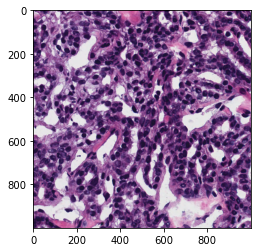

In [4]:
#source = "TCGA-HT-8564-01Z-00-DX1"
#_id = dataset.image_from_source_map["Monuseg.{}".format(source)]
_id = 0
image = dataset.load_image(_id)
gt_mask = dataset.load_mask(_id)[0]
plt.imshow(image[:,:,0:3])

In [5]:
intensity_thresh = 0.7 # For visualization
all_masks = []
for model in model_list:
    masks = model.detect([image], binarize = False)[0]["masks"]
    masks = masks / masks.max() * 255
    masks = masks.astype(np.uint8)
    all_masks.append(masks)

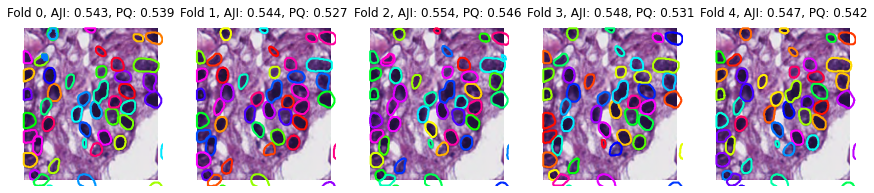

In [6]:
# Display results (only crops to make sure we can still see something)
# Calc and display scores for each fold on figure
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(np.ravel(axs)):
    m = all_masks[i] > intensity_thresh * 255
    visualize.display_instances(image[0:256, 0:256, 0:3], utils.extract_bboxes(m), m, np.ones(m.shape[-1]), 
                                ["BG", ""], np.ones(m.shape[-1]), ax = ax, use_captions=False, show_mask = False, show_bbox = False)
    aji, pq = utils.calc_aji_pq(m, gt_mask)
    ax.set_title("Fold {}, AJI: {:3.3f}, PQ: {:3.3f}".format(i, aji, pq) )


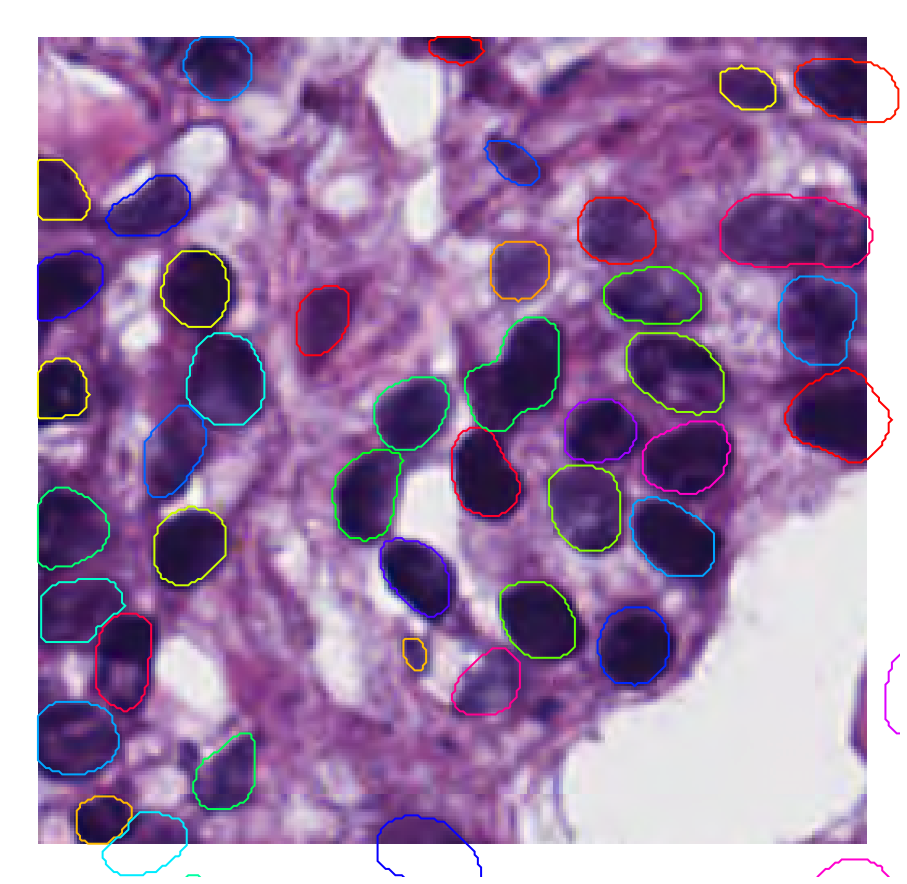

In [7]:
# Merge detections
_all_masks = np.concatenate(all_masks, axis = -1)
merged_mask = utils.mask_merge2(_all_masks)
# Visualize crop
visualize.display_instances(image[0:256, 0:256, 0:3], utils.extract_bboxes(m), m, np.ones(m.shape[-1]), 
                            ["BG", ""], np.ones(m.shape[-1]), use_captions=False, show_mask = False, show_bbox = False)


In [8]:
print(utils.calc_aji_pq(merged_mask, gt_mask))

(0.5593684031737558, 0.5449073495811919)
